# <center>Домашнее задание </center>

#### Текст домашнего задания
<div class="alert alert-block alert-info">
Подготовить данные для модели:
    
1. Анализ данных, необходимые корректировки. 
2. Обработать пропуски. 
3. Оценить выбросы. 
4. Корреляция. 
5. Тест на нормальность распределения.
6. Масштабировать и стандартизировать данные.
</div>

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 320)
pd.set_option('display.width', 80)

import re

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from scipy import stats
from scipy.stats import normaltest, norm

# Позволяет выводить несколько результатов 
# из одной ячейки кода без print
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#%config InlineBackend.figure_format = 'svg'

## Выполнение задания

### Загрузка и анализ данных <a id="1"></a>

In [2]:
# Загружаем часть данных для предварительного просмотра. 
# Кодировка выбрана здесь: 
# https://docs.python.org/3/library/codecs.html#standard-encodings,
# для кириллицы "cp1251"

raw_df = pd.read_csv('credit_train.csv', sep=';', encoding="cp1251", 
                     nrows=3)
raw_df

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,NaN,NaN,UMN,"59998,00",10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1,1,0
1,2,F,NaN,MAR,UMN,"10889,00",6,1.1,NaN,NaN,МОСКВА,NaN,2,0,0
2,3,M,32.0,MAR,SPC,"10728,00",12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5,0,0


In [3]:
# Извлечение списка столбцов
col_list = raw_df.columns.tolist()
print(col_list)

['client_id', 'gender', 'age', 'marital_status', 'job_position', 'credit_sum', 'credit_month', 'tariff_id', 'score_shk', 'education', 'living_region', 'monthly_income', 'credit_count', 'overdue_credit_count', 'open_account_flg']


In [4]:
# Переменная 'client_id' не нужна
my_cols = col_list[1:]

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             3 non-null      int64  
 1   gender                3 non-null      object 
 2   age                   1 non-null      float64
 3   marital_status        2 non-null      object 
 4   job_position          3 non-null      object 
 5   credit_sum            3 non-null      object 
 6   credit_month          3 non-null      int64  
 7   tariff_id             3 non-null      float64
 8   score_shk             0 non-null      float64
 9   education             1 non-null      object 
 10  living_region         3 non-null      object 
 11  monthly_income        1 non-null      float64
 12  credit_count          3 non-null      int64  
 13  overdue_credit_count  3 non-null      int64  
 14  open_account_flg      3 non-null      int64  
dtypes: float64(4), int64(5), ob

In [6]:
my_dtype={"gender": object, "age": float, "marital_status": object,
          "job_position": object, "credit_sum": float,
          "credit_month": object, "tariff_id": object, 
          "score_shk": float, "education": object, "living_region": object, 
          "monthly_income": float, "open_account_flg": object}

Загружаем все данные с необходимыми столбцами. В переменных `credit_sum` и `score_shk` в качестве десятичного разделителя используется запятая, добавим аргумент `decimal = ","`. 

In [7]:
df_beta = pd.read_csv('credit_train.csv', usecols = my_cols, dtype = my_dtype,
                      sep=';', encoding="cp1251", decimal = ",")

In [8]:
df_beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  object 
 6   tariff_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  object 
dtypes: float64(6), object(8)
memory usage: 18.2+ MB


С использованием библиотеки __[Pandas Profiling](https://github.com/pandas-profiling/pandas-profiling)__ можно быстро сделать развернутый анализ данных.

<div class="alert alert-block alert-danger">
Время выполнения следующей ячейки кода зависит от конфигурации компьютера, у меня ориентировочно <b>42 сек</b> (проц. Intel Core i7-9700K). Можно не запускать эту ячейку, далее информация о получении данных будет дополнена выводом из стандартных методов <b>info</b> и <b>describe</b>.
</div>

In [9]:
#%%time
#pandas_profiling.ProfileReport(df_beta)

In [10]:
df_beta.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0


In [11]:
df_beta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gender                170746 non-null  object 
 1   age                   170743 non-null  float64
 2   marital_status        170743 non-null  object 
 3   job_position          170746 non-null  object 
 4   credit_sum            170744 non-null  float64
 5   credit_month          170746 non-null  object 
 6   tariff_id             170746 non-null  object 
 7   score_shk             170739 non-null  float64
 8   education             170741 non-null  object 
 9   living_region         170554 non-null  object 
 10  monthly_income        170741 non-null  float64
 11  credit_count          161516 non-null  float64
 12  overdue_credit_count  161516 non-null  float64
 13  open_account_flg      170746 non-null  object 
dtypes: float64(6), object(8)
memory usage: 18.2+ MB


Предварительный анализ от `Pandas Profiling` показывает, что датасет содержит 1145 дублирующихся строк. 
Дубликаты строк на основе всех столбцов также можно найти с помощью метода `duplicated`.

In [12]:
df_duplicateRows = df_beta[df_beta.duplicated()]
df_duplicateRows.shape

(1145, 14)

 Удалим дубликаты, сохранив только первый вариант из строк-дублей (`keep='first'`).

In [13]:
df_beta["is_duplicate"] = df_beta.duplicated(keep='first')
df = df_beta[df_beta["is_duplicate"]==False]
df = df.drop(["is_duplicate"], axis=1).reset_index()
df.shape

(169601, 15)

В соответствии с информацией от `Pandas Profiling` значения зависимой переменной распределяются следующим образом:
* Количество значений "0" - 140690, т.е., 82.4% от всех наблюдений;
* Количество значений "1" - 30056, т.е., 17.6% от всех наблюдений.

In [14]:
# Распределение классов после удаления дублей
df.open_account_flg.value_counts()

0    139545
1     30056
Name: open_account_flg, dtype: int64

В датасете несбалансированное распределение классов.

### Анализ и обработка пропущенных данных.

In [15]:
df.isnull().sum()

index                      0
gender                     0
age                        3
marital_status             3
job_position               0
credit_sum                 2
credit_month               0
tariff_id                  0
score_shk                  7
education                  5
living_region            189
monthly_income             5
credit_count            9190
overdue_credit_count    9190
open_account_flg           0
dtype: int64

In [16]:
df_na_small = df[df.age.isna() | df.marital_status.isna() | 
                 df.credit_sum.isna() | df.score_shk.isna() | 
                 df.education.isna() | df.monthly_income.isna()]
df_na_small

# Количество наблюдений с пропущенными значениями в переменных, исключая
# переменные "living_region", "credit_count", "overdue_credit_count"
df_na_small.shape[0]

,index,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,0,M,NaN,NaN,UMN,59998.00,10,1.6,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
1,1,F,NaN,MAR,UMN,10889.00,6,1.1,NaN,NaN,МОСКВА,NaN,2.0,0.0,0
2,2,M,32.0,MAR,SPC,10728.00,12,1.1,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.0,0.0,0
3,3,F,27.0,NaN,SPC,12009.09,12,1.1,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.0,0.0,0
4,4,M,45.0,NaN,SPC,NaN,10,1.1,0.421385,SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.0,0.0,0
5,5,F,NaN,MAR,SPC,NaN,10,1.1,NaN,SCH,СТАВРОПОЛЬСКИЙ КРАЙ,30000.0,0.0,0.0,0
6,6,M,34.0,MAR,SPC,10317.00,6,1.5,NaN,SCH,ОБЛ НИЖЕГОРОДСКАЯ,28000.0,3.0,0.0,0
8,8,M,23.0,UNM,SPC,37577.16,12,1.6,NaN,SCH,ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА,50000.0,3.0,0.0,0
11,11,F,26.0,UNM,SPC,18936.00,10,1.32,0.455774,NaN,РЕСП. БАШКОРТОСТАН,30000.0,0.0,0.0,0
14,14,F,32.0,MAR,SPC,12711.00,12,1.5,0.411186,NaN,РЕСП БАШКОРТОСТАН,30000.0,3.0,0.0,0


11

Один из вариантов дальнейших действий с этими пропусками - после разделения датасета на обучающую и тестовую выборки заполнить пропуски медианами для переменных `age`, `credit_sum`, `score_shk`, `monthly_income` и модами для `marital_status` и `education`.
Однако, количество наблюдений с пропущенными значениями в переменных датасета, исключая переменные `living_region`, `credit_count` и`overdue_credit_count`, составляет 11, это всего 0.0064 % от всех наблюдений. Удаление столь незначительного количества наблюдений не должно оказать заметного влияния на точность прогнозирования с учетом того, что значения целевой переменной для этих наблюдений принадлежат мажоритарному классу ("0"). 

Удаляем 11 выделенных строк с пропущенными значениями.  

In [17]:
ind_drop = list(df_na_small.index)
df.drop(df.index[ind_drop], inplace=True)
df = df.drop(["index"], axis=1)

##### Обработка переменных `overdue_credit_count`  и  `credit_count`

Переменные `overdue_credit_count` и `credit_count` содержат одинаковое количество пропущенных значений. Проверим - в одних и тех же строках? Ответ - да.

In [18]:
df['credit_count'][df['overdue_credit_count'].isnull()].isnull().sum()

9190

Создаем новую переменную "no_creditInfo" - со значениями 1, если значение 'credit_count' и 'overdue_credit_count' == nan, и 0, если нет.

In [19]:
df['no_creditInfo'] = np.where(df.credit_count.isna(), 1, 0)
df['no_creditInfo'] = df['no_creditInfo'].astype('object')

In [20]:
df[df["no_creditInfo"]==1].head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_creditInfo
25,F,22.0,UNM,SPC,30000.0,18,1.1,0.550770,UGR,РЕСП. БАШКОРТОСТАН,30000.0,NaN,NaN,1,1
50,F,35.0,MAR,SPC,13779.0,10,1.6,0.677837,GRD,ОБЛ НОВОСИБИРСКАЯ,28000.0,NaN,NaN,0,1
52,F,33.0,DIV,DIR,15379.2,10,1.22,0.566717,GRD,САНКТ-ПЕТЕРБУРГ,60000.0,NaN,NaN,0,1
72,M,21.0,UNM,ATP,14309.0,10,1.1,0.293619,SCH,МОСКВА,30000.0,NaN,NaN,1,1
74,F,27.0,MAR,SPC,15248.0,10,1.6,0.591578,SCH,ОРЕНБУРГСКАЯ ОБЛ,10000.0,NaN,NaN,0,1


In [21]:
df['credit_count'].unique()
df['credit_count'].describe()

array([ 3.,  7.,  2.,  1.,  4.,  6.,  0.,  5., nan,  8., 10.,  9., 12.,
       11., 14., 15., 13., 16., 19., 17., 18., 21.])

count    160400.000000
mean          2.107332
std           1.776505
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          21.000000
Name: credit_count, dtype: float64

In [22]:
df['credit_count'].value_counts()

1.0     44980
2.0     36730
0.0     25616
3.0     23756
4.0     14011
5.0      7509
6.0      3889
7.0      1945
8.0      1000
9.0       472
10.0      219
11.0      127
12.0       72
13.0       31
14.0       15
15.0       13
17.0        5
16.0        4
19.0        3
18.0        2
21.0        1
Name: credit_count, dtype: int64

In [23]:
df['overdue_credit_count'].value_counts()

0.0    153066
1.0      7282
2.0        47
3.0         5
Name: overdue_credit_count, dtype: int64

In [24]:
df['overdue_credit_count'].unique()
df['overdue_credit_count'].describe()

array([ 0., nan,  1.,  2.,  3.])

count    160400.000000
mean          0.046079
std           0.211492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.000000
Name: overdue_credit_count, dtype: float64

Самое популярное значение `overdue_credit_count` **0**, заполняем этим значением пропущенные в `overdue_credit_count` и `credit_count`.

In [25]:
df['credit_count'] = df['credit_count'].fillna(0).astype('int')
df['overdue_credit_count'] = df['overdue_credit_count'].fillna(0).astype('int')

In [26]:
df['credit_count'] = df['credit_count'].astype('object')
df['overdue_credit_count'] = df['overdue_credit_count'].astype('object')

df['credit_count'].unique()
df['overdue_credit_count'].unique()

array([3, 7, 2, 1, 4, 6, 0, 5, 8, 10, 9, 12, 11, 14, 15, 13, 16, 19, 17,
       18, 21], dtype=object)

array([0, 1, 2, 3], dtype=object)

##### Обработка переменной ` living_region `

Обработка этой переменной сделана не мной, я только немного корректировала код под свое мнение. Благодарность написавшему, из-за ограничений по времени вообще удалила бы этот столбец. 

In [27]:
# Уникальные значения переменной living_region
# и их количество
print('Количество уникальных значений переменной '
          '"living_region": {}.\n'.format(df['living_region'].nunique()))

Количество уникальных значений переменной "living_region": 301.



In [28]:
# уникальные значения переменной living_region
regions = df['living_region'].unique()

In [29]:
len(df['living_region'].value_counts())

301

In [30]:
regions = pd.Series(data=regions, 
                    index=regions, name='regions')

In [31]:
# задаем список стоп-слов
stopwrds = set(['ОБЛ','ОБЛАСТЬ', 'РЕСП', 'РЕСПУБЛИКА', 
                'КРАЙ', 'Г', 'АО', 'АОБЛ', 'АВТОНОМНАЯ'])

In [32]:
def clean_region(x):
    '''
    Функция для предобработки значений серии
    Аргумент:
    x - pd.Series
    '''
    x = re.sub('[.,]+', ' ', str(x))
    wrds = x.split(' ')
    wrds_new = []
    for w in wrds:
        if not w in stopwrds:
            wrds_new.append(w)
    x = ''.join(wrds_new)
    return x

regions = regions.map(clean_region)

Есть числовые значения в форме строки, переопределены согласно __[Автомобильные коды регионов России](https://autotraveler.ru/russia/avtomobilnye-kody-regionov-rossii.html#.XhXiO0f7RPY)__.

In [33]:
# корректировки в regions
regions['ЧУКОТСКИЙ АO'] = 'ЧУКОТСКИЙ'
regions['ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШИЯ ЧУВАШСКАЯ РЕСПУБЛИКА -'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['РЕСП ЧУВАШСКАЯ - ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ - ЧУВАШИЯ РЕСП'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШСКАЯ-ЧУВАШИЯ'] = 'ЧУВАШСКАЯ'
regions['ЧУВАШИЯЧУВАШСКАЯ-'] = 'ЧУВАШСКАЯ'
regions['РЕСПУБЛИКАТАТАРСТАН'] = 'ТАТАРСТАН'
regions['ПРИВОЛЖСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ'] = 'МОСКОВСКАЯ'
regions['ПРИВОЛЖСКИЙФЕДЕРАЛЬНЫЙОКРУГ'] = 'МОСКОВСКАЯ'
regions['ПЕРМСКАЯ ОБЛ'] = 'ПЕРМСКИЙ'
regions['ОРЁЛ'] = 'ОРЛОВСКАЯ'
regions['Г.ОДИНЦОВО МОСКОВСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['ОДИНЦОВОМОСКОВСКАЯ'] = 'МОСКОВСКАЯ'
regions['МЫТИЩИНСКИЙ Р-Н'] = 'МОСКОВСКАЯ'
regions['МОСКОВСКИЙ П'] = 'МОСКОВСКАЯ'
regions['КАМЧАТСКАЯ ОБЛАСТЬ'] = 'КАМЧАТСКИЙ'
regions['ДАЛЬНИЙ ВОСТОК'] = 'ДАЛЬНИЙВОСТОК'
regions['ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н'] = 'ВЛАДИМИРСКАЯ'
regions['ГУСЬ-ХРУСТАЛЬНЫЙР-Н'] = 'ВЛАДИМИРСКАЯ'
regions['ГОРЬКОВСКАЯ ОБЛ'] = 'НИЖЕГОРОДСКАЯ'
regions['ЭВЕНКИЙСКИЙ АО'] = 'КРАСНОЯРСКИЙ'
regions['ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['ХАНТЫ-МАНСИЙСКИЙАВТОНОМНЫЙОКРУГ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['ХАНТЫ-МАНСИЙСКИЙАВТОНОМНЫЙОКРУГ-Ю'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['АО ХАНТЫ-МАНСИЙСКИЙ-ЮГРА'] = 'ХАНТЫ-МАНСИЙСКИЙ'
regions['СЕВ. ОСЕТИЯ - АЛАНИЯ'] = 'СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ'
regions['РЕСП. САХА (ЯКУТИЯ)'] ='САХА/ЯКУТИЯ/'
regions['РЕСПУБЛИКА САХА'] = 'САХА/ЯКУТИЯ/'
regions['САХА'] = 'САХА/ЯКУТИЯ/'
regions['98'] = 'САНКТ-ПЕТЕРБУРГ'
regions['74'] = 'ЧЕЛЯБИНСКАЯ'
regions['РОССИЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ'] = 'МОСКОВСКАЯ'
regions['МОСКВОСКАЯ ОБЛ'] = 'МОСКОВСКАЯ'
regions['ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['Г. ЧЕЛЯБИНСК'] = 'ЧЕЛЯБИНСКАЯ'
regions['БРЯНСКИЙ'] = 'БРЯНСКАЯ'

In [34]:
type(regions)

pandas.core.series.Series

In [35]:
df['living_region'] = df['living_region'].map(regions)
df['living_region'] = df['living_region'].fillna("IDN")

In [36]:
df['living_region'].nunique()

86

In [37]:
df = df.reset_index(drop=True)

In [38]:
df.isnull().sum()

gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
tariff_id               0
score_shk               0
education               0
living_region           0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
no_creditInfo           0
dtype: int64

### Дополнительная обработка переменных

In [39]:
# Общая информация по категориальным признакам
df.describe(include=[object])

,gender,marital_status,job_position,credit_month,tariff_id,education,living_region,credit_count,overdue_credit_count,open_account_flg,no_creditInfo
count,169590,169590,169590,169590,169590,169590,169590,169590,169590,169590,169590
unique,2,5,18,31,33,5,86,21,4,2,2
top,F,MAR,SPC,10,1.1,SCH,МОСКОВСКАЯ,1,0,0,0
freq,88092,93307,133711,94875,68892,86986,12735,44980,162256,139534,160400


По переменным `job_position`, `tariff_id` и `living_region` можно рассмотреть возможность уменьшения количества категорий.

###### `job_position`

In [40]:
df['job_position'].value_counts().tail(10)

WOI    351
INP    240
BIU    125
WRP    110
PNI     65
PNV     40
PNS     12
HSK      8
INV      5
ONB      1
Name: job_position, dtype: int64

In [41]:
df.loc[df['job_position'].value_counts()[df['job_position']].values < 60,
             'job_position'] = 'OTH'

In [42]:
df['job_position'].describe()

count     169590
unique        14
top          SPC
freq      133711
Name: job_position, dtype: object

###### `tariff_id`

In [43]:
df['tariff_id'].value_counts().tail(10)

1.25    54
1.18    36
1.26    11
1.28    10
1.52     7
1.27     6
1.48     5
1.56     2
1.96     1
1.29     1
Name: tariff_id, dtype: int64

In [44]:
df.loc[df['tariff_id'].value_counts()[df['tariff_id']].values < 30, 
         'tariff_id'] = 1.99

In [45]:
df['tariff_id'].describe()

count     169590
unique        26
top          1.1
freq       68892
Name: tariff_id, dtype: object

###### `living_region`

In [46]:
df['living_region'].value_counts().tail(15)

ХАКАСИЯ                  476
КАМЧАТСКИЙ               407
СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ    377
КАЛМЫКИЯ                 304
ЕВРЕЙСКАЯ                201
nan                      189
НЕНЕЦКИЙ                 172
МАГАДАНСКАЯ              159
ДАГЕСТАН                  69
АЛТАЙ                     54
ЧЕЧЕНСКАЯ                 31
ЧУКОТСКИЙ                 31
ИНГУШЕТИЯ                 19
ЧИТИНСКАЯ                 17
ДАЛЬНИЙВОСТОК              1
Name: living_region, dtype: int64

In [47]:
df.loc[df['living_region'].value_counts()[df['living_region']].values < 70, 
         'living_region'] = 'OTHERS'

In [48]:
df['living_region'].describe()

count         169590
unique            80
top       МОСКОВСКАЯ
freq           12735
Name: living_region, dtype: object

In [49]:
df.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,no_creditInfo
0,F,26.0,UNM,SPC,47878.0,10,1.1,0.512525,GRD,МОСКОВСКАЯ,60000.0,3,0,0,0
1,F,32.0,UNM,SPC,26268.0,10,1.1,0.465026,GRD,СТАВРОПОЛЬСКИЙ,39500.0,7,0,0,0
2,M,26.0,MAR,SPC,16793.0,14,1.0,0.445430,SCH,САНКТ-ПЕТЕРБУРГ,36000.0,2,0,0,0
3,M,37.0,MAR,SPC,42289.0,10,1.6,0.691609,SCH,АРХАНГЕЛЬСКАЯ,70000.0,1,0,0,0
4,M,43.0,MAR,INP,57567.0,10,1.1,0.341164,GRD,ХАНТЫ-МАНСИЙСКИЙ,60000.0,7,0,0,0


##### Корреляция числовых признаков

In [50]:
# Матрицу корреляции заменим более компактным и
# достаточно информативным вариантом представления
corrs = df.corr().abs()
np.fill_diagonal(corrs.values, 0)

s = corrs.unstack()
so = s.sort_values(kind="quicksort")
so

age             age               0.000000
credit_sum      credit_sum        0.000000
score_shk       score_shk         0.000000
monthly_income  monthly_income    0.000000
age             monthly_income    0.014507
monthly_income  age               0.014507
credit_sum      score_shk         0.054172
score_shk       credit_sum        0.054172
age             credit_sum        0.096189
credit_sum      age               0.096189
score_shk       monthly_income    0.107393
monthly_income  score_shk         0.107393
age             score_shk         0.166599
score_shk       age               0.166599
credit_sum      monthly_income    0.351102
monthly_income  credit_sum        0.351102
dtype: float64

Переменные для списков по типам признаков:

In [51]:
num_columns = [i for i in df.columns if df[i].dtype.name!='object']
cat_columns = [i for i in df.columns if df[i].dtype.name=='object']

cat_columns.remove('open_account_flg')
print('Категориальные признаки: ' + str(cat_columns))

Категориальные признаки: ['gender', 'marital_status', 'job_position', 'credit_month', 'tariff_id', 'education', 'living_region', 'credit_count', 'overdue_credit_count', 'no_creditInfo']


In [52]:
print('Числовые признаки: ' + str(num_columns))

Числовые признаки: ['age', 'credit_sum', 'score_shk', 'monthly_income']


##### Проверка нормальности распределения числовых предикторов

Проверка наличия выбросов и графики распределения. 

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'age')]

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'credit_sum')]

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'score_shk')]

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 0, 'monthly_income')]

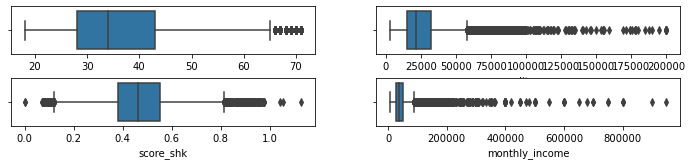

In [53]:
fig, ax = plt.subplots(2,2,figsize=(12,2.2))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
k=0;
for i in num_columns:
    axes = sns.boxplot(df[i], ax=ax[k//2,k%2]);
    axes.set(xlabel=i)
    k += 1

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='credit_sum', ylabel='Density'>

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score_shk', ylabel='Density'>

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monthly_income', ylabel='Density'>

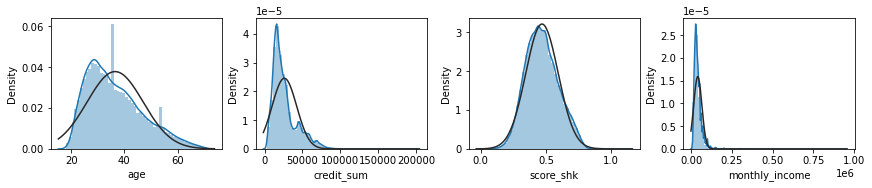

In [54]:
names = list(num_columns)
fig, axes = plt.subplots(1, 4, constrained_layout=True, figsize=(12,2.5))

for i,t in enumerate(names):
    sns.distplot(df[t], fit=norm, bins=50, ax=axes[i % 4]);

После перебора различных методов скалирования выбран QuantileTransformer, который дал лучший результат. 

In [55]:
df_norm = df.copy()
transform_feature = QuantileTransformer(output_distribution='normal')
df_norm[names] = transform_feature.fit_transform(df[names])

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='credit_sum', ylabel='Density'>

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score_shk', ylabel='Density'>

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='monthly_income', ylabel='Density'>

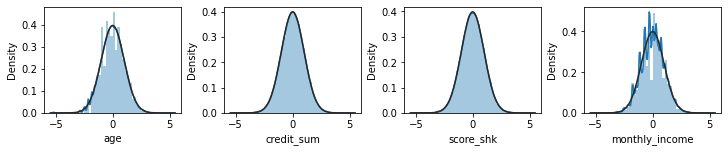

In [56]:
fig, axes = plt.subplots(1, 4, constrained_layout=True, figsize=(10,2.0))

for i,t in enumerate(names):
    sns.distplot(df_norm[t], fit=norm, bins=50, ax=axes[i % 4])

Применим тест `jarque_bera` и `normaltest` (from scipy.stats) для проверки нормальности распределения после применения QuantileTransformer. 

In [57]:
# тест jarque_bera, позаимствовала из ДЗ2 Павла Дубовика) 

norm_test = pd.DataFrame(index=names, columns=['p_value','dist_type'])
for i in names:
    norm_test.loc[i, ['p_value']] = stats.jarque_bera(df_norm[i])[1]
    if stats.jarque_bera(df_norm[i])[1] >= 0.05:
        norm_test.loc[i, ['dist_type']] = 'normal'
    else:
        norm_test.loc[i, ['dist_type']] = 'not normal'
        
norm_test        

,p_value,dist_type
age,0.0,not normal
credit_sum,0.416749,normal
score_shk,0.030182,not normal
monthly_income,0.000832,not normal


In [58]:
transformed_k2, transformed_p = normaltest(df_norm[names])
transformed_p

array([3.13457027e-126, 4.18027753e-001, 2.77561479e-002, 6.24148622e-004])

Распределение соответствует нормальному, если значение p > 0.05. Условие соблюдается не для всех переменных, даже если визуально распределение практически нормальное.  

Для категориальных переменных применяем дамми-кодирование.

In [59]:
#df = pd.DataFrame({'A': ['a', 'b', 'a'], 'B': ['b', 'a', 'c'],
#                   'C': [1, 2, 3]})

In [60]:
#df

In [61]:
#pd.get_dummies(df, prefix=['A', 'B'])

In [62]:
df_cat = pd.get_dummies(df[cat_columns])

In [63]:
df_num = df[num_columns]

In [64]:
df_target = df.open_account_flg

Объединение:

In [65]:
data = pd.concat((df_num, df_cat, df_target), axis=1)

In [66]:
data.head()

,age,credit_sum,score_shk,monthly_income,gender_F,gender_M,marital_status_CIV,marital_status_DIV,marital_status_MAR,marital_status_UNM,marital_status_WID,job_position_ATP,job_position_BIS,job_position_BIU,job_position_DIR,job_position_INP,job_position_NOR,job_position_OTH,job_position_PNA,job_position_PNI,job_position_SPC,job_position_UMN,job_position_WOI,job_position_WRK,job_position_WRP,credit_month_10,credit_month_11,credit_month_12,credit_month_13,credit_month_14,credit_month_15,credit_month_16,credit_month_17,credit_month_18,credit_month_19,credit_month_20,credit_month_21,credit_month_22,credit_month_23,credit_month_24,credit_month_25,credit_month_26,credit_month_27,credit_month_28,credit_month_29,credit_month_3,credit_month_30,credit_month_31,credit_month_32,credit_month_36,...,living_region_САХА/ЯКУТИЯ/,living_region_САХАЛИНСКАЯ,living_region_СВЕРДЛОВСКАЯ,living_region_СЕВЕРНАЯОСЕТИЯ-АЛАНИЯ,living_region_СМОЛЕНСКАЯ,living_region_СТАВРОПОЛЬСКИЙ,living_region_ТАМБОВСКАЯ,living_region_ТАТАРСТАН,living_region_ТВЕРСКАЯ,living_region_ТОМСКАЯ,living_region_ТУЛЬСКАЯ,living_region_ТЫВА,living_region_ТЮМЕНСКАЯ,living_region_УДМУРТСКАЯ,living_region_УЛЬЯНОВСКАЯ,living_region_ХАБАРОВСКИЙ,living_region_ХАКАСИЯ,living_region_ХАНТЫ-МАНСИЙСКИЙ,living_region_ЧЕЛЯБИНСКАЯ,living_region_ЧУВАШСКАЯ,living_region_ЯМАЛО-НЕНЕЦКИЙ,living_region_ЯРОСЛАВСКАЯ,credit_count_0,credit_count_1,credit_count_2,credit_count_3,credit_count_4,credit_count_5,credit_count_6,credit_count_7,credit_count_8,credit_count_9,credit_count_10,credit_count_11,credit_count_12,credit_count_13,credit_count_14,credit_count_15,credit_count_16,credit_count_17,credit_count_18,credit_count_19,credit_count_21,overdue_credit_count_0,overdue_credit_count_1,overdue_credit_count_2,overdue_credit_count_3,no_creditInfo_0,no_creditInfo_1,open_account_flg
0,26.0,47878.0,0.512525,60000.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,32.0,26268.0,0.465026,39500.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,26.0,16793.0,0.445430,36000.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,37.0,42289.0,0.691609,70000.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,43.0,57567.0,0.341164,60000.0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [67]:
# Разделение данных на обучающую и тестовую выборки
y = data.open_account_flg
X = data.drop(['open_account_flg'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      train_size=0.8, 
                                                      random_state=42)

In [68]:
y_train

13842     0
13358     0
30722     1
149341    1
53358     1
         ..
119879    0
103694    1
131932    0
146867    0
121958    0
Name: open_account_flg, Length: 135672, dtype: object

### Моделирование

#### Pipeline

QuantileTransformer
- Преобразуйте функции, используя информацию квантилей.

- Этот метод преобразует объекты, чтобы они соответствовали равномерному или нормальному распределению. Следовательно, для данной функции это преобразование имеет тенденцию распространять наиболее часто встречающиеся значения. Это также уменьшает влияние (маргинальных) выбросов: поэтому это надежная схема предварительной обработки.

In [69]:
# Препроцессинг для числовых переменных
numerical_transformer = QuantileTransformer(output_distribution='normal')

preprocessor = ColumnTransformer(transformers=[('num', 
                                                numerical_transformer, 
                                                num_columns)])

ColumnTransformer
- Применяет преобразователи к столбцам массива или pandas DataFrame.

- Этот оценщик позволяет отдельно преобразовывать различные столбцы или подмножества столбцов входных данных, а признаки, сгенерированные каждым преобразователем, будут объединяться для формирования единого пространства признаков. Это полезно для разнородных или столбчатых данных, чтобы объединить несколько механизмов извлечения признаков или преобразований в один преобразователь.

In [70]:
# Модель RandomForest
forest = RandomForestClassifier(n_estimators=800, max_depth=17, 
                                random_state=2020, n_jobs=-1)

In [71]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', forest)])
my_pipeline.fit(X_train, y_train);

preds = my_pipeline.predict(X_test)

# Оценка модели
score_auc = roc_auc_score(y_test, preds)
print('AUC: ', score_auc)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  QuantileTransformer(output_distribution='normal'),
                                                  ['age', 'credit_sum',
                                                   'score_shk',
                                                   'monthly_income'])])),
                ('model',
                 RandomForestClassifier(max_depth=17, n_estimators=800,
                                        n_jobs=-1, random_state=2020))])

AUC:  0.5151337840306488


#### RandomForest

##### На переменных без масштабирования

In [72]:
forest.fit(X_train, y_train);

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

RandomForestClassifier(max_depth=17, n_estimators=800, n_jobs=-1,
                       random_state=2020)

AUC на обучающей выборке: 0.849
AUC на контрольной выборке: 0.754


##### Масштабируем переменные

In [73]:
# transform_feature определена ранее в проверке нормальности распределения
# transform_feature = QuantileTransformer(output_distribution='normal')
transform_feature.fit(X_train)
X_train_scaled = transform_feature.transform(X_train)
X_test_scaled = transform_feature.transform(X_test)

QuantileTransformer(output_distribution='normal')

In [74]:
forest.fit(X_train, y_train);

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train_scaled)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test_scaled)[:, 1])))

RandomForestClassifier(max_depth=17, n_estimators=800, n_jobs=-1,
                       random_state=2020)

AUC на обучающей выборке: 0.732
AUC на контрольной выборке: 0.693


### Выводы

1. Недостаточно знаний для объяснения, почему масштабирование переменных или масштабирование только числовых переменных (в Pipeline) не привело к улучшению оценки работы модели RandomForest.
2. В качестве учебной работы такое представление обработки данных имеет право быть, но, возможно, на определенном этапе лучше обернуть обработку в функцию или класс.  